# Preparación del dataset de Vertimientos Hídricos

### 1. librerias que vamos a usar

In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings('ignore')

#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot

### 2. Carga y Exploración Inicial de Datos

Estos dataset, fueron extraidos del SIMEM (llamados: ReservasHidraulicasEnergía.xlsx y VertimientosHidricos.xlsx). Los cuales seran usados para la predicción de un modelo de clasificación, indicando si hay vertimientos (1) o no (0) en los embalses.

In [3]:
# Cargar los datasets
reservas = pd.read_excel('Data/ReservasHidraulicasEnergía.xlsx')
vertimientos = pd.read_excel('Data/VertimientosHidricos.xlsx')

# Exploración inicial
print("=== Reservas Hidrológicas ===")
print(reservas.info())
print("\nPrimeras filas:\n", reservas.head())

print("\n=== Vertimientos Hidrológicos ===")
print(vertimientos.info())
print("\nPrimeras filas:\n", vertimientos.head())

=== Reservas Hidrológicas ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106472 entries, 0 to 106471
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   FechaPublicacion          106472 non-null  object 
 1   Fecha                     106472 non-null  object 
 2   CodigoEmbalse             106472 non-null  object 
 3   RegionHidrologica         106472 non-null  object 
 4   VolumenUtilDiarioEnergia  106472 non-null  int64  
 5   CapacidadUtilEnergia      106472 non-null  int64  
 6   VolumenTotalEnergia       106472 non-null  int64  
 7   VertimientosEnergia       106472 non-null  float64
 8   Total                     0 non-null       float64
dtypes: float64(2), int64(3), object(4)
memory usage: 7.3+ MB
None

Primeras filas:
   FechaPublicacion       Fecha CodigoEmbalse RegionHidrologica  \
0       2023-12-19  2013-01-31  AGREGADO_SIN          Colombia   
1       2023-12-19  2013-01

# 3. Limpieza y Preparación de Datos

### Para el dataset de Reservas:

In [21]:
# Renombrar columnas para consistencia
reservas = reservas.rename(columns={
    'CodigoEmbalse': 'codigo_embalse',
    'RegionHidrologica': 'region',
    'VolumenUtilDiarioEnergia': 'volumen_util',
    'CapacidadUtilEnergia': 'capacidad_util',
    'VolumenTotalEnergia': 'volumen_total'
})

# Convertir fecha y eliminar columnas innecesarias
reservas['fecha'] = pd.to_datetime(reservas['Fecha'])
reservas = reservas.drop(['Fecha', 'FechaPublicacion', 'Total'], axis=1)

### Para el dataset de Vertimientos:

In [22]:
# Renombrar columnas
vertimientos = vertimientos.rename(columns={
    'CodigoEmbalse': 'codigo_embalse',
    'VertimientosEnergia': 'vertimientos',
    'CodigoDuracion': 'duracion'
})

# Convertir fecha
vertimientos['fecha'] = pd.to_datetime(vertimientos['Fecha'])
vertimientos = vertimientos.drop('Fecha', axis=1)

# 4. Verificación de Claves para el Merge

In [23]:
# Verificar duplicados en las claves
print("Duplicados en Reservas:", reservas.duplicated(['fecha', 'codigo_embalse']).sum())
print("Duplicados en Vertimientos:", vertimientos.duplicated(['fecha', 'codigo_embalse']).sum())

# Verificar valores únicos
print("\nEmbalses únicos en Reservas:", reservas['codigo_embalse'].nunique())
print("Embalses únicos en Vertimientos:", vertimientos['codigo_embalse'].nunique())

# Verificar solapamiento temporal
print("\nRango de fechas Reservas:", reservas['fecha'].min(), "a", reservas['fecha'].max())
print("Rango de fechas Vertimientos:", vertimientos['fecha'].min(), "a", vertimientos['fecha'].max())

Duplicados en Reservas: 1
Duplicados en Vertimientos: 1

Embalses únicos en Reservas: 26
Embalses únicos en Vertimientos: 27

Rango de fechas Reservas: 2013-01-01 00:00:00 a 2025-03-31 00:00:00
Rango de fechas Vertimientos: 2013-01-01 00:00:00 a 2025-03-31 00:00:00


# 4. Realización del Merge

In [24]:
df_final = pd.merge(
    reservas,
    vertimientos,
    on=['fecha', 'codigo_embalse'],
    how='left',  # Mantener todos los registros de reservas
    suffixes=('', '_vert')
)

# Rellenar NA en vertimientos
df_final['vertimientos'] = df_final['vertimientos'].fillna(0)

In [25]:
# Crear etiqueta binaria
df_final['etiqueta'] = (df_final['vertimientos'] > 0).astype(int)

# Verificar distribución
print("\nDistribución de etiquetas:")
print(df_final['etiqueta'].value_counts(normalize=True))


Distribución de etiquetas:
etiqueta
0    0.919577
1    0.080423
Name: proportion, dtype: float64


In [26]:
print("\n=== Dataset Final ===")
print(f"Registros totales: {len(df_final)}")
print("Estructura:")
print(df_final.info())
print("\nMuestra de datos:")
print(df_final.sample(5))


=== Dataset Final ===
Registros totales: 106474
Estructura:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106474 entries, 0 to 106473
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   codigo_embalse       106474 non-null  object        
 1   region               106474 non-null  object        
 2   volumen_util         106474 non-null  int64         
 3   capacidad_util       106474 non-null  int64         
 4   volumen_total        106474 non-null  int64         
 5   VertimientosEnergia  106474 non-null  float64       
 6   fecha                106474 non-null  datetime64[ns]
 7   vertimientos         106474 non-null  float64       
 8   duracion             103492 non-null  object        
 9   etiqueta             106474 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 8.1+ MB
None

Muestra de datos:
      codigo_embalse     re

In [27]:
#Lista de variables categóricas
catCols = df_final.select_dtypes(include = ["object", 'category']).columns.tolist()

df_final[catCols].head(2)

,codigo_embalse,region,duracion
0,AGREGADO_SIN,Colombia,P1D
1,PORCE2,Antioquia,NaN


In [28]:
#Lista de variables numéricas

numCols=df_final.select_dtypes(include = ['float64','int32','int64']).columns.tolist()


df_final[numCols].head(2)

,volumen_util,capacidad_util,volumen_total,VertimientosEnergia,vertimientos,etiqueta
0,9132098700,15174371537,10263118000,0.0,0.0,0
1,5139300,133945086,71858700,0.0,0.0,0


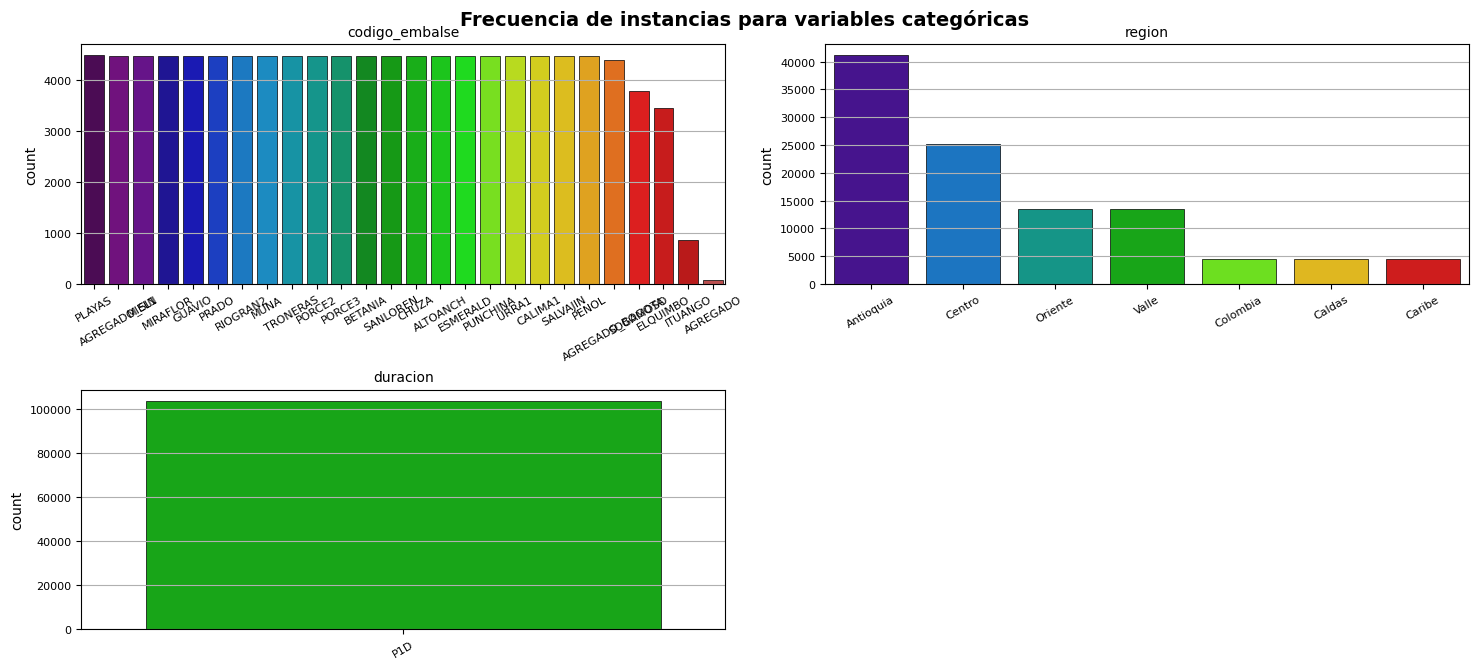

In [29]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(2, df_final , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

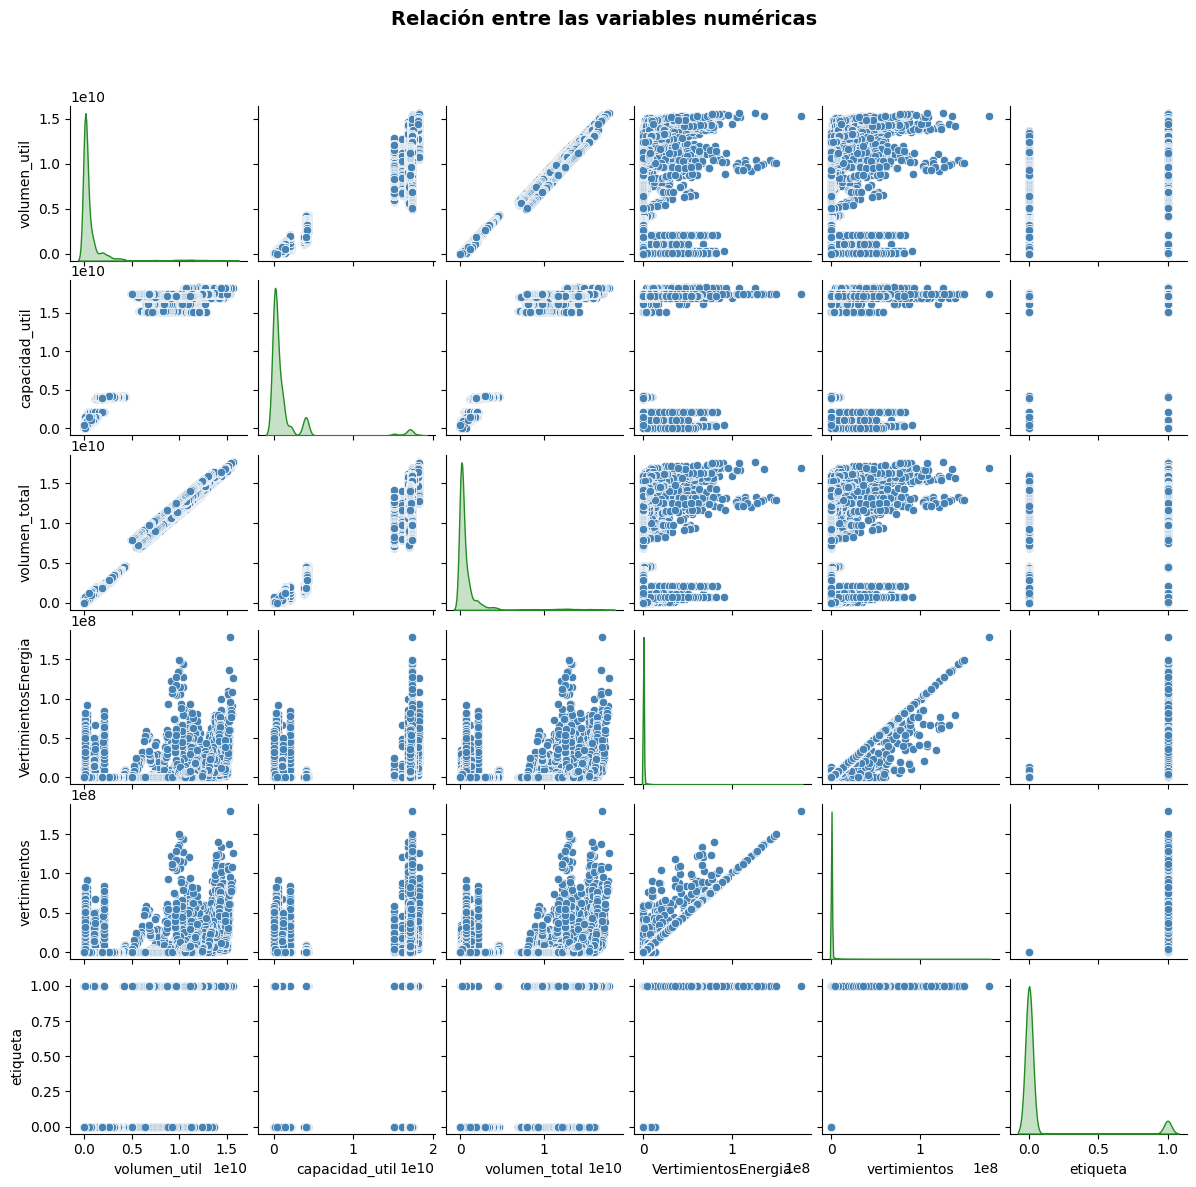

In [30]:
#Visualización de variables numéricas
multiple_plot(1, df_final , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [11]:
df_final.to_csv('Data/ReservasVertimientos_Merged.csv', index=False)

### Variable de salida

In [33]:
df_final.groupby('etiqueta').etiqueta.count().sort_values(ascending=False)

etiqueta
0    97911
1     8563
Name: etiqueta, dtype: int64

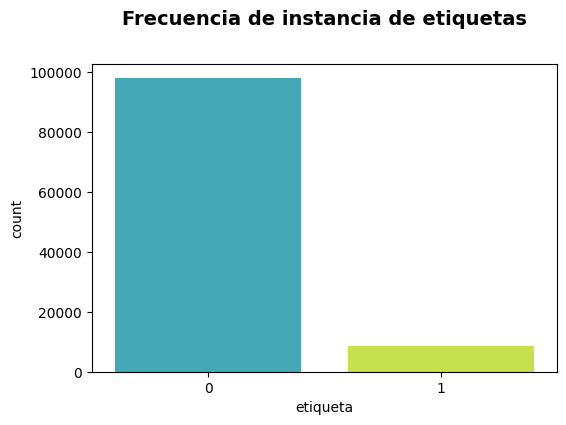

In [36]:
multiple_plot(1, df_final, None, 'etiqueta', 'countplot', 'Frecuencia de instancia de etiquetas', 0)

### Datos de prueba

In [37]:
# Porcentaje de filas para la primera parte (por ejemplo, 90%)
percentage_first_part = 0.90

# Número de filas para la primera parte
n_rows_part1 = int(len(df_final) * percentage_first_part)

# Obtener índices aleatorios para la primer parte
indices_part1 = df_final.sample(n=n_rows_part1, random_state=123).index

# Obtener índices para la segunda parte (resto de las filas)
indices_part2 = df_final.index.difference(indices_part1)

# Dividir el DataFrame en dos partes
df = df_final.loc[indices_part1]
dp = df_final.loc[indices_part2]

### Valores atípicos para las variables de entreda

In [40]:
#utilización de LocalOutlierFactor con 13 vecinos para identificar valores atípicos en las variables de entrada


# crear un objeto LocalOutlierFactor con n_neighbors=13
lof = LocalOutlierFactor(n_neighbors=13, contamination=0.1)

# identificar los valores atípicos por medio de lof
y_pred = lof.fit_predict(df[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', df[outliers].index.tolist())

Indices de valores atípicos:  [10487, 82800, 51136, 871, 84351, 34287, 93834, 14671, 219, 106393, 230, 89745, 443, 95740, 11381, 2987, 14809, 612, 95960, 82483, 102452, 58802, 98409, 70350, 11987, 38489, 77070, 37970, 59235, 61090, 73992, 69192, 98350, 43612, 30671, 49214, 28330, 88078, 25491, 31414, 38046, 3125, 33756, 85912, 22570, 84953, 29808, 3807, 17908, 72500, 75717, 2674, 2991, 71846, 8304, 90926, 100104, 74208, 59996, 91915, 71253, 103018, 76745, 15697, 101553, 3157, 26730, 94710, 50275, 56584, 82180, 52731, 104129, 69145, 12008, 15721, 25653, 47506, 73450, 53961, 102315, 93546, 101485, 27600, 17326, 55765, 25086, 50987, 80384, 31187, 95210, 49977, 806, 32741, 101327, 81638, 77539, 32219, 10032, 47068, 73212, 101773, 82325, 61131, 24459, 50414, 16257, 105034, 46329, 11337, 93462, 59412, 22374, 87474, 55971, 89857, 26894, 62580, 33727, 14420, 486, 2656, 4697, 76808, 99911, 11232, 49652, 56596, 13696, 103377, 17042, 73969, 40164, 47028, 96361, 72920, 75775, 70100, 21292, 80809, 

In [41]:
# Eliminar los valores atípicos del dataframe original
df = df.loc[~outliers]

In [42]:
df.shape

(86243, 10)

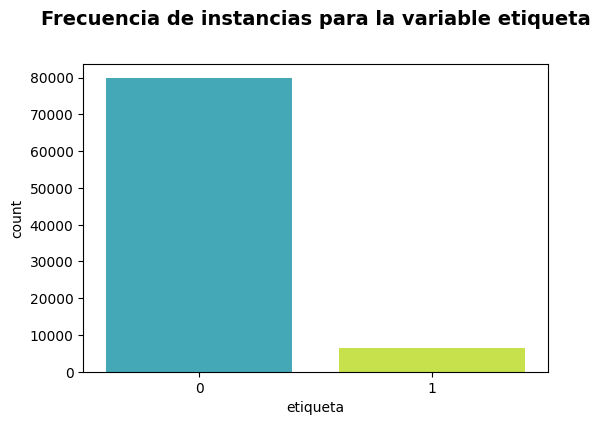

In [43]:
multiple_plot(1, df , None, 'etiqueta', 'countplot', 'Frecuencia de instancias para la variable etiqueta',0)

In [44]:
df.groupby('etiqueta').etiqueta.count().sort_values(ascending=False)

etiqueta
0    79769
1     6474
Name: etiqueta, dtype: int64

### Sobremuestreo (oversampling)

In [48]:
# Se crea un objeto RandomOverSampler que permite crear copias aleatorias de las muestras de la clase
# minoritaria para igualar el número de muestras entre las diferentes clases.
oversampler = RandomOverSampler()

# Se realiza el sobremuestreo para las variables de entrada y salida
X_resampled, y_resampled = oversampler.fit_resample(df.drop('etiqueta', axis=1), df['etiqueta'])

# Se crean dos dataframes con las variables de entrada y otro con la variable de salida a partir del proceso anterior
df1 = pd.DataFrame(X_resampled, columns=df.columns.drop('etiqueta'))
df2 = pd.DataFrame(y_resampled)

# Se concatenan los dataframes horizontalmente
df_balanced = pd.concat([df1, df2], axis=1)

df=df_balanced

In [49]:
df.shape

(159538, 10)

In [50]:
# Dataset balanceado
df.head(2)

,codigo_embalse,region,volumen_util,capacidad_util,volumen_total,VertimientosEnergia,fecha,vertimientos,duracion,etiqueta
0,PUNCHINA,Antioquia,45561700,73393113,57998600,0.0,2018-04-29,0.0,P1D,0
1,ALTOANCH,Valle,6656600,33849942,15112900,0.0,2016-02-17,0.0,P1D,0


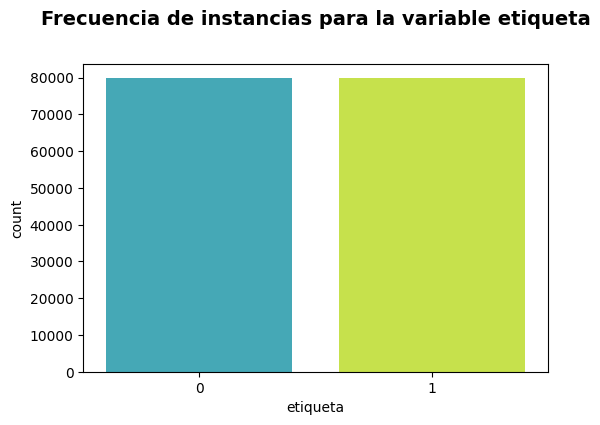

In [51]:
multiple_plot(1, df , None, 'etiqueta', 'countplot', 'Frecuencia de instancias para la variable etiqueta',0)

# Exportar el dataset

In [54]:
# Exportamos el dataframe a un archivo CSV
df.to_csv('./Data/clas_Vertimiento_Prep.csv', index=False)
dp.to_csv('./Data/clas_Vertimiento_Prue.csv', index=False)